In [1]:
!pip install uv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 40.6 MB/s eta 0:00:00


In [2]:
!uv pip install torch torchvision -q

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


МАСКА ИСКЛЮЧЕНИЯ ИЗ ВНИМАНИЯ БАННЕРОВ

In [60]:
def create_text_mask_by_location(image):
    h, w = image.shape[:2]
    # Создаем пустую маску (255 - область интереса, 0 - текст/баннеры)
    text_mask = np.ones((h, w), dtype=np.uint8) * 255

    # Координаты баннеров (исправленные на основе предположений)
    # Первый баннер: [45, 474] (x1, y1) и [334, 524] (x2, y2)
    x1, y1 = min(45, 334), min(474, 524)  # Верхний левый угол
    x2, y2 = max(45, 334), max(474, 524)  # Нижний правый угол
    text_mask[y1:y2, x1:x2] = 0

    # Второй баннер: [879, 2] (x1, y1) и [1072, 50] (x2, y2)
    x1, y1 = min(879, 1072), min(2, 50)  # Верхний левый угол
    x2, y2 = max(879, 1072), max(2, 50)  # Нижний правый угол
    text_mask[y1:y2, x1:x2] = 0

    return text_mask


МАСКА ДЛЯ КАМНЕЙ (ЖЁЛТЫХ И КРАСНЫХ)

In [62]:
def find_contours_of_cards(image, text_mask):
    # Применяем маску текста, чтобы исключить баннеры
    image_masked = cv2.bitwise_and(image, image, mask=text_mask)

    # Преобразование в HSV для камней
    hsv = cv2.cvtColor(image_masked, cv2.COLOR_BGR2HSV)

    # Диапазоны для желтых камней
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Диапазоны для красных камней (два диапазона, так как красный цвет в HSV делится на два участка)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 230, 230])
    lower_red2 = np.array([160, 50, 50])
    upper_red2 = np.array([180, 230, 230])
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask_red1, mask_red2)

    # Объединяем маски для желтых и красных камней
    mask = cv2.bitwise_or(mask_yellow, mask_red)

    # Применяем маску текста еще раз, чтобы исключить остатки
    mask = cv2.bitwise_and(mask, mask, mask=text_mask)

    # Морфологические операции для очистки маски
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Удаление шума
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Заполнение разрывов

    # Поиск контуров
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Фильтрация контуров по площади (игнорируем мелкие объекты)
    filtered_contours = [cnt for cnt in contours if 200 < cv2.contourArea(cnt) < 500]

    return filtered_contours, mask

Тестовый кадр, Оригинал


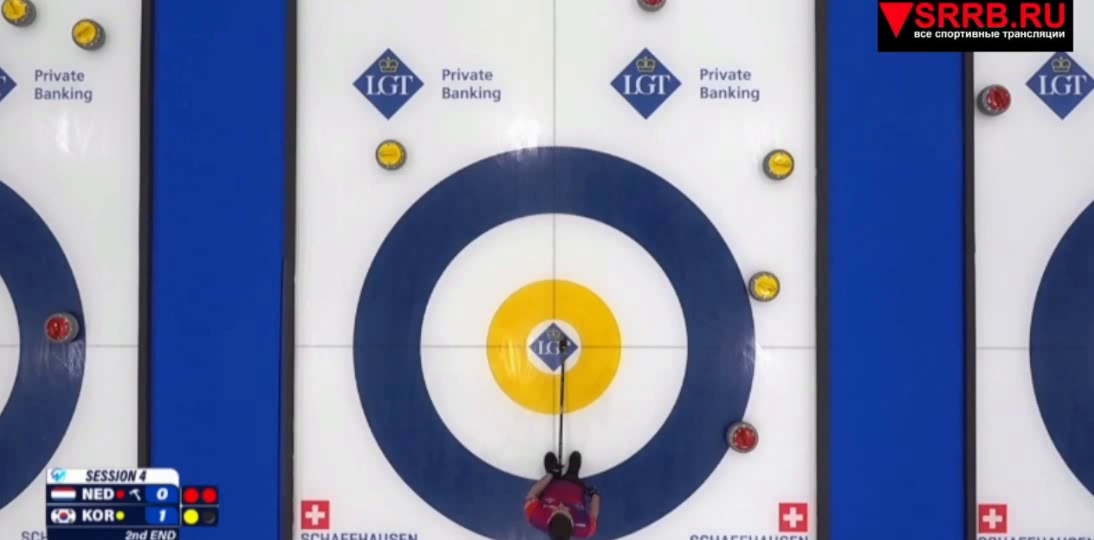

Местоположению маски баннеров


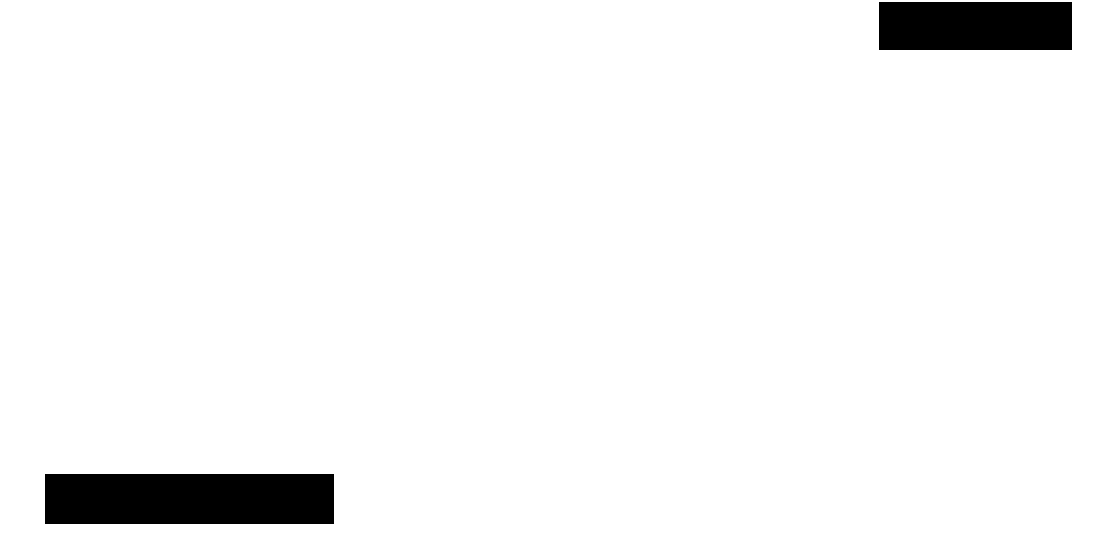

Маска для камней


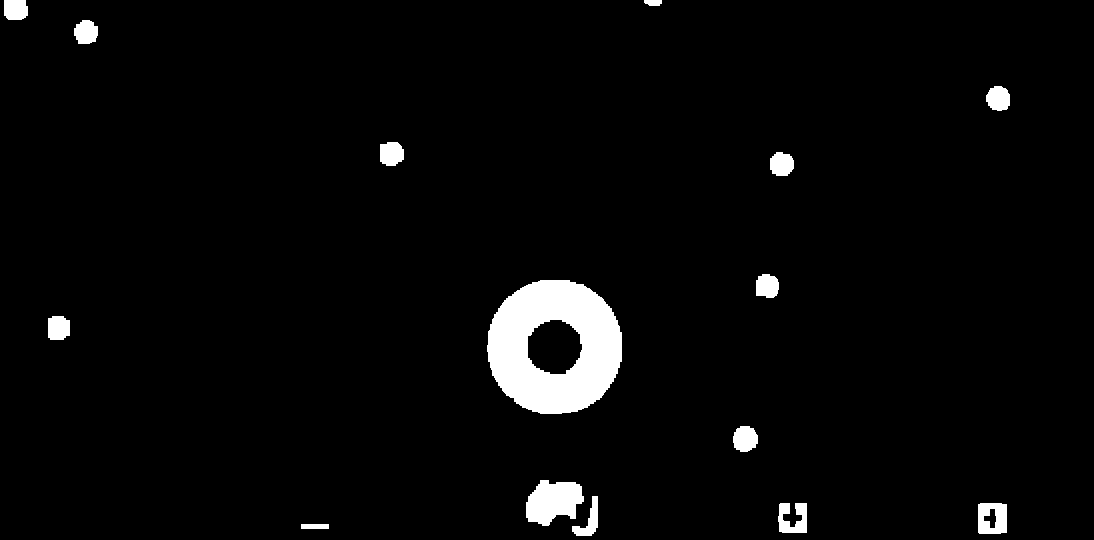

Тестовый кадр, Контур


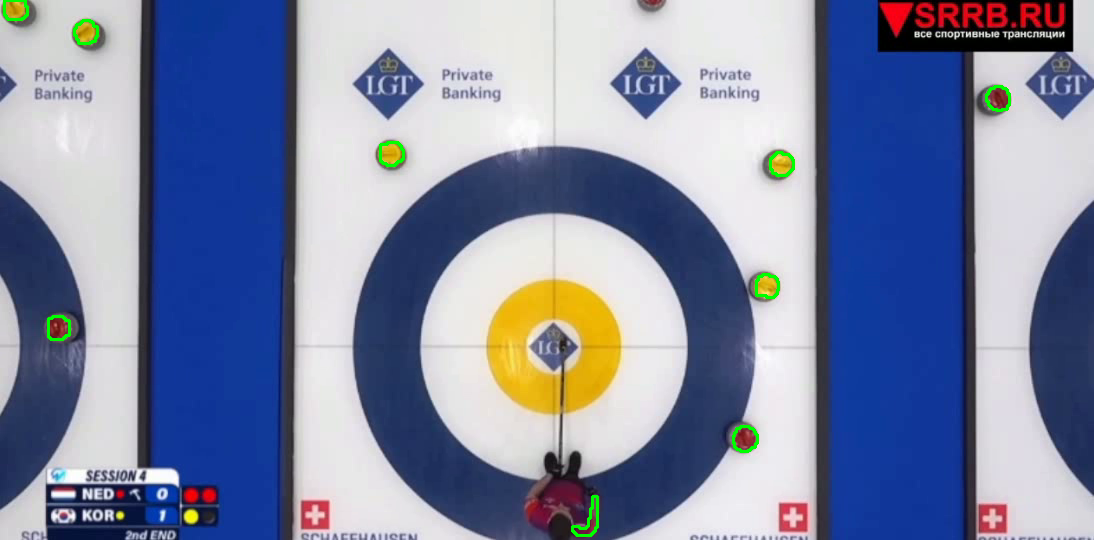

In [63]:
# Загрузка и обработка кадра
video_path = '/content/drive/MyDrive/Sber_Test/1_end.mp4'
cap = cv2.VideoCapture(video_path)
frame_number = 6920
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()

if ret:
    print("Тестовый кадр, Оригинал")
    cv2_imshow(frame)

    # Создаем маску для баннеров по координатам
    text_mask = create_text_mask_by_location(frame)
    print("Местоположению маски баннеров")
    cv2_imshow(text_mask)

    # Применяем маску баннеров и находим контуры
    contours, mask = find_contours_of_cards(frame, text_mask)

    # Показать финальную маску камней
    print("Маска для камней")
    cv2_imshow(mask)

    # Нарисовать контуры на изображении
    contour_image = frame.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    print("Тестовый кадр, Контур")
    cv2_imshow(contour_image)
else:
    print("Ошибка: не удалось извлечь кадр")

cap.release()

МАСКА ДЛЯ "ДОМА"

In [7]:
def find_contours_of_cards(image):
    # Преобразование в HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    print(f"HSV: ")
    cv2_imshow(frame)

    # Пример диапазона для выделения объектов (например, синих камней)
    lower_range = np.array([100, 150, 0])  # Нижняя граница H, S, V
    upper_range = np.array([140, 255, 255])  # Верхняя граница H, S, V

    mask = cv2.inRange(hsv, lower_range, upper_range)
    print(f"Mask: ")
    cv2_imshow(mask)  # Показать маску

    # Морфологические операции для улучшения маски
    kernel = np.ones((5, 5), np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Удаление шума
    print(f"Mask Удалён шум: ")
    cv2_imshow(mask)

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Заполнение разрывов
    print(f"Mask Запонены разрывы: ")
    cv2_imshow(mask)

    # Поиск контуров
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

Тестовый кадр, Оригинал


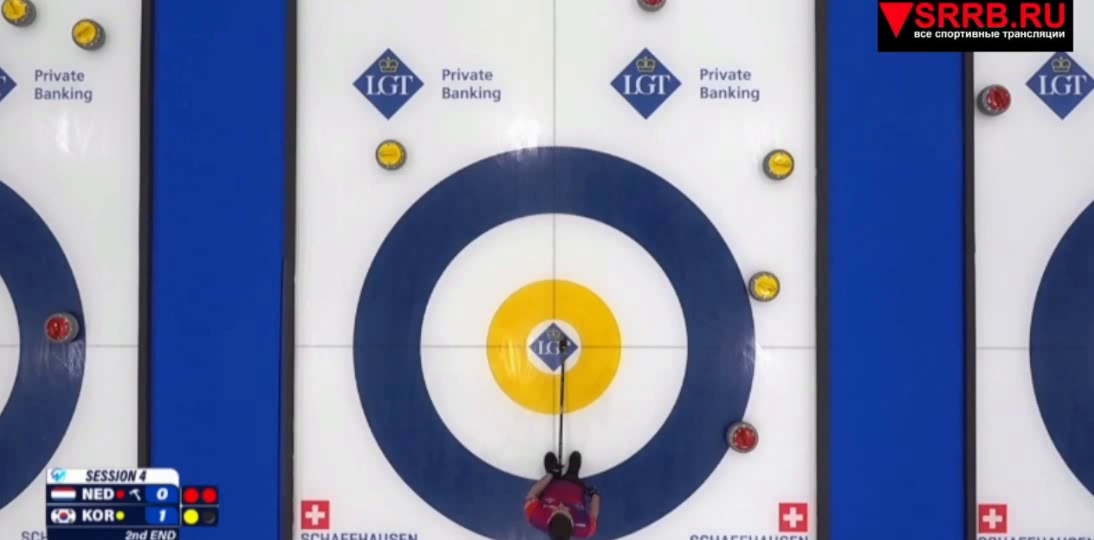

HSV: 


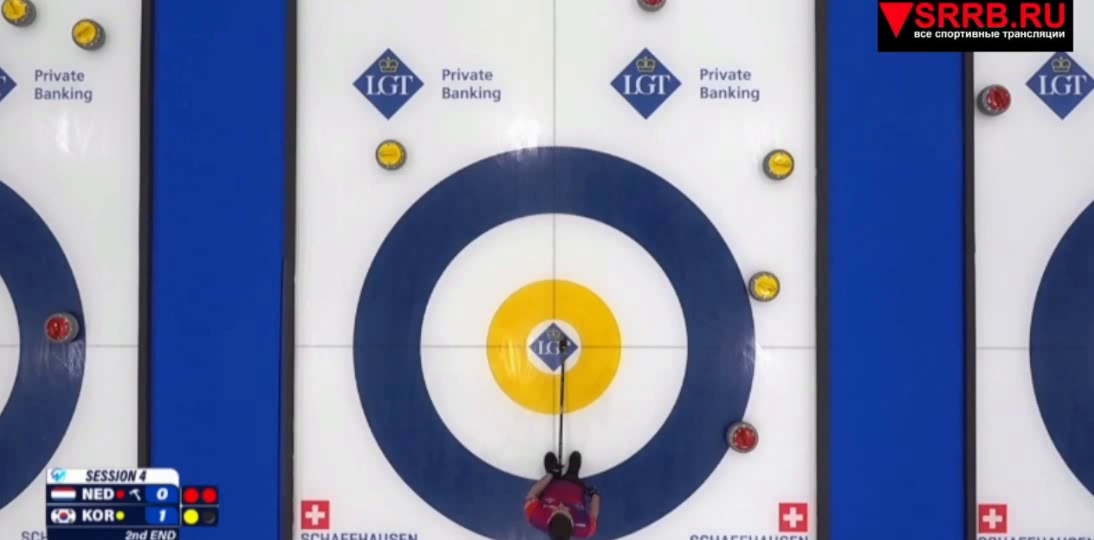

Mask: 


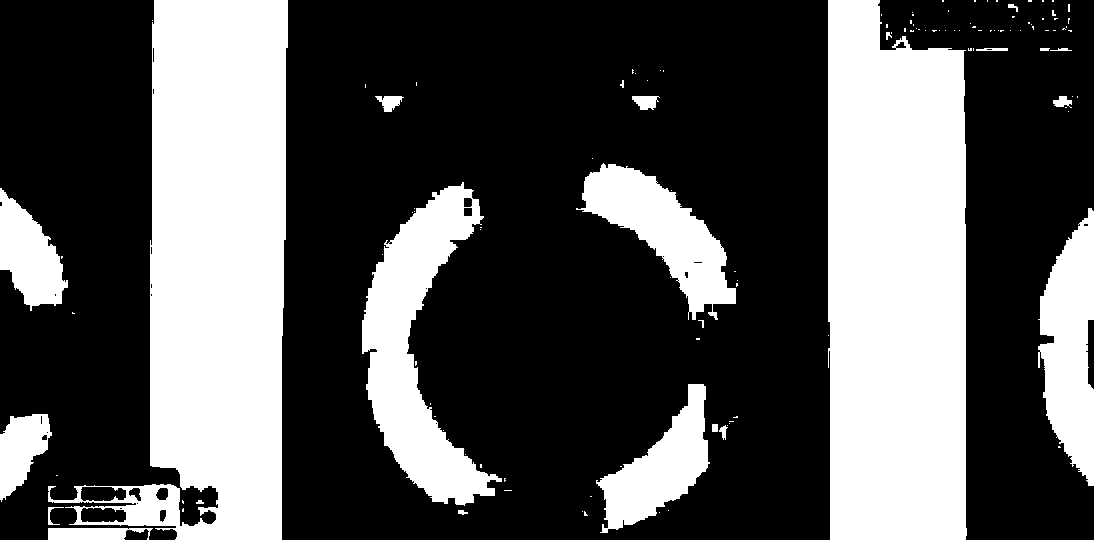

Mask Удалён шум: 


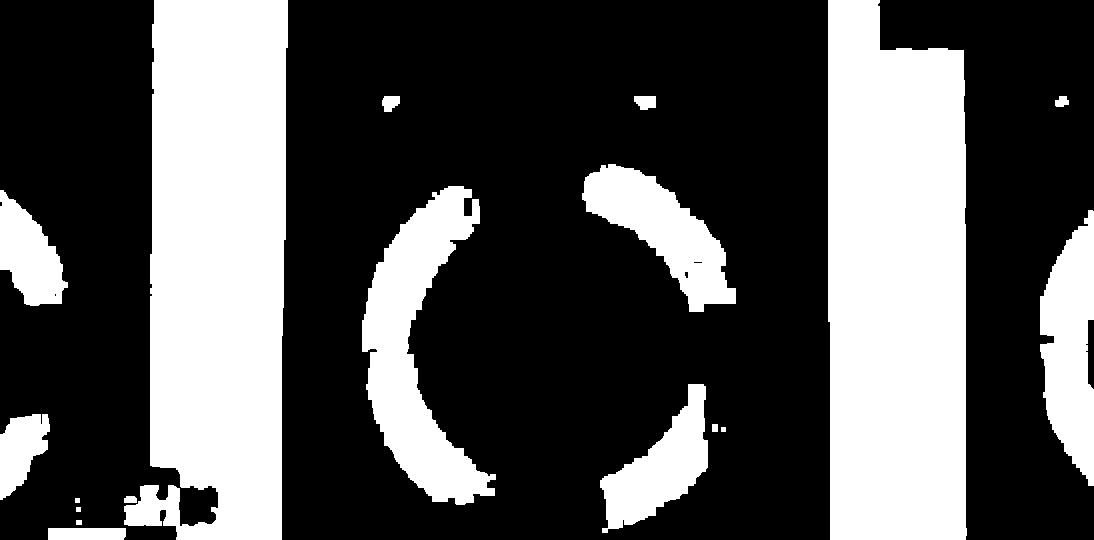

Mask Запонены разрывы: 


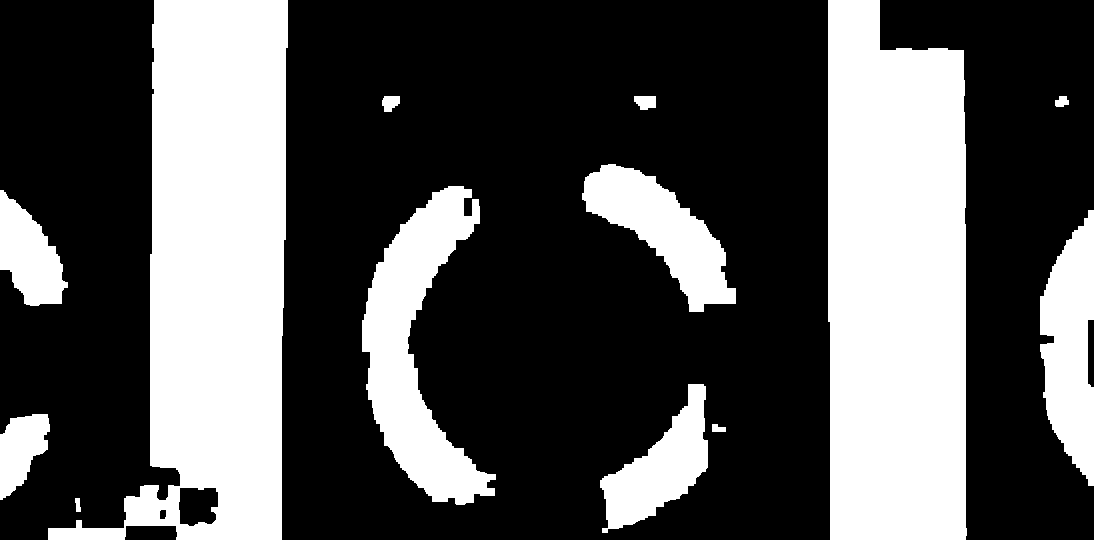

Тестовый кадр, Контур


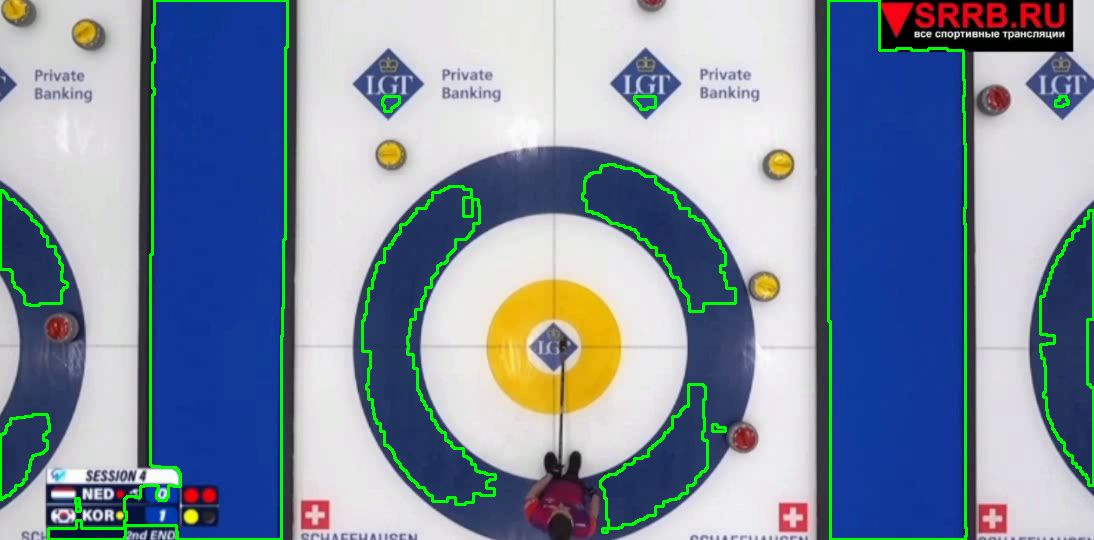

In [8]:
# Загрузка видеофайла и остальной код остается без изменений
video_path = '/content/drive/MyDrive/Sber_Test/1_end.mp4'
cap = cv2.VideoCapture(video_path)
frame_number = 6920
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()

if ret:
    print("Тестовый кадр, Оригинал")
    cv2_imshow(frame)

    contours = find_contours_of_cards(frame)
    contour_image = frame.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    print("Тестовый кадр, Контур")
    cv2_imshow(contour_image)
else:
    print("Ошибка: не удалось извлечь кадр")

cap.release()